## <font color="Blue">Phishing URL Detection - ConvXGB Model</font>

<b>GOAL:</b> This study employs new deep learning algorithm named "ConvXGB" to the field of cybersecurity in detecting phishing URL.</br>
<b>Author :</b> Saravanan Muthuramalingam </br>
<b>Purpose of this notebook :</b> This Notebook handles the following,
    <li> Hyperparamter Tuning </li>
    <li> EPOCH = 100 </li>

    

In [1]:
# import all required python libraries
#-------------------------------------#
# Statistics Libraries
import numpy as np

# Dataset related Libraires
import pandas as pd 
import csv

# Data Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# URL Parsing Libraries
import urllib.parse
from urllib.parse import urlparse
from urllib.parse import urlsplit
from urlpath import URL

# OS and regular expression Libraries
import re
import glob
import os

# Image processing related Libraries
from PIL import Image
import cv2
import skimage.measure
import imghdr

# Image validation related Libraries
from difPy import dif
from sklearn.preprocessing import OneHotEncoder

# To Build CNN in Keras 
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, Adadelta, RMSprop

# XGBoost classification algorithm
from xgboost import XGBClassifier

# Perforrmance evaluation Librraries
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


#### <font color='blue'>7. Splitting Train/Test Data</font>

In [2]:
#spliting test and train
#80% of the datasets is reserved for training the model
raw_df = pd.read_csv(r'C:\Users\msara\Desktop\dataset\preprocessed_data.csv')
#raw_df = raw_df.drop(columns=['protocol'])
raw_df['split'] = np.random.randn(raw_df.shape[0], 1)

#msk = np.random.rand(len(raw_df)) <= 0.8

#train = raw_df[msk]
#test = raw_df[~msk]

In [3]:
y = raw_df.pop('result')

X = raw_df

Text(0.5, 1.0, 'Phishing vs Legitmate count')

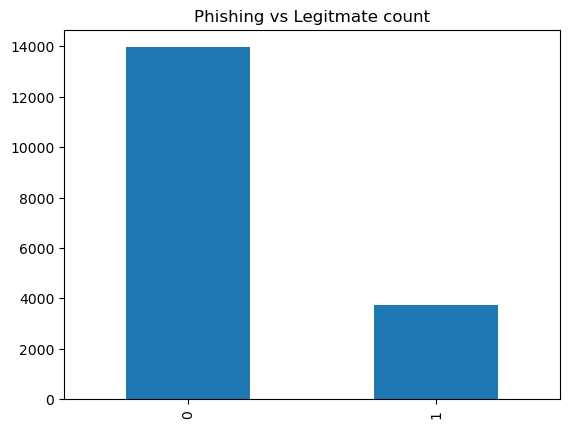

In [4]:
#before class imablance
y.value_counts().plot.bar()
plt.title("Phishing vs Legitmate count")

In [5]:
y.value_counts()

0    13948
1     3735
Name: result, dtype: int64

In [6]:
print("class 0:",11724 *100/(11724+3259),"%")
print("class 1:",3259* 100/(11724+3259))

class 0: 78.24868183941801 %
class 1: 21.75131816058199


In [7]:
print(X.shape)
print(y.shape)

(17683, 786)
(17683,)


#### Handling Class Imbalance

In [8]:
#classs imabalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [9]:
#Oversampling results
print(X_res.shape)
print(y_res.shape)

(27896, 786)
(27896,)


In [10]:
new_df = pd.concat([X_res,y_res],axis=1)

In [11]:
new_df.head(5)

,Unnamed: 0,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,pixel785,split,result
0,0,161.0,161.0,161.0,161.0,161.0,161.0,161.0,161.0,161.0,...,85.0,151.0,155.0,94.0,65.0,69.0,68.0,68.0,-0.663690,0
1,1,253.0,253.0,253.0,252.0,253.0,223.0,204.0,206.0,201.0,...,4.0,2.0,3.0,4.0,4.0,4.0,4.0,4.0,-0.265376,0
2,2,100.0,106.0,106.0,102.0,102.0,101.0,117.0,109.0,104.0,...,192.0,192.0,65.0,37.0,46.0,44.0,44.0,39.0,-0.556710,0
3,3,229.0,224.0,249.0,238.0,229.0,236.0,235.0,244.0,248.0,...,247.0,246.0,241.0,240.0,240.0,237.0,239.0,244.0,-0.807883,0
4,4,234.0,234.0,230.0,233.0,230.0,218.0,222.0,232.0,233.0,...,48.0,49.0,45.0,38.0,39.0,39.0,39.0,39.0,0.068029,0


<AxesSubplot:>

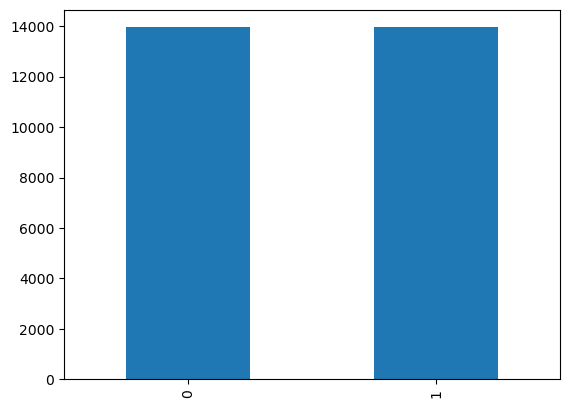

In [12]:
#after class imablance
y_res.value_counts().plot.bar()

In [13]:
raw_df = new_df.copy()
raw_df = raw_df.drop(['Unnamed: 0', 'split'],axis=1)
raw_df.shape

(27896, 785)

#### <font color='blue'>9. Train/Test Data Pre-processing</font>

In [14]:
# Removing unwanted columns from train dataset
#train = train.drop(['Unnamed: 0', 'protocol','split'],axis=1)
#print("Train_data shape:", train.shape)

# Removing unwanted columns from test dataset
#test = test.drop(['Unnamed: 0', 'protocol', 'split'],axis=1)
#print("Test_data shape:", test.shape)

In [15]:
msk = np.random.rand(len(raw_df)) <= 0.7

train = raw_df[msk]
test = raw_df[~msk]

In [16]:
print(train.shape)
print(test.shape)

(19493, 785)
(8403, 785)


In [17]:
#converting the data to appropripate shapes using numpy
train_data = train[:]
val_data = test[400:]
train_label = np.float32(train_data.result)
val_label = np.float32(val_data.result)
train_image = np.float32(train_data[train_data.columns[1:]])
val_image = np.float32(val_data[val_data.columns[1:]])
test_image = np.float32(test[test.columns[1:]])
test_label = np.float32(test.result)
print('train shape: %s'%str(train_data.shape))
print('val shape: %s'%str(val_data.shape))
print('train_label shape: %s'%str(train_label.shape))
print('val_label shape: %s'%str(val_label.shape))
print('train_image shape: %s'%str(train_image.shape))
print('val_image shape: %s'%str(val_image.shape))
print('test_image shape: %s'%str(test_image.shape))
print('test_label shape: %s'%str(test_label.shape))

train shape: (19493, 785)
val shape: (8003, 785)
train_label shape: (19493,)
val_label shape: (8003,)
train_image shape: (19493, 784)
val_image shape: (8003, 784)
test_image shape: (8403, 784)
test_label shape: (8403,)


In [18]:


plt.show()
print(train_image.shape)

train_image = train_image/255.0
val_image = val_image/255.0
test_image = test_image/255.0

print(train_image.shape)

#28 x 28 = 784
train_image = train_image.reshape(train_image.shape[0],28,28,1)
val_image = val_image.reshape(val_image.shape[0],28,28,1)
test_image = test_image.reshape(test_image.shape[0],28,28,1)


print('train_image shape: %s'%str(train_image.shape))

print('train_image shape: %s'%str(train_image.shape))
print('val_image shape: %s'%str(val_image.shape))

train_label1 = train_label
val_label1 = val_label
print(val_label1.shape)

(19493, 784)
(19493, 784)
train_image shape: (19493, 28, 28, 1)
train_image shape: (19493, 28, 28, 1)
val_image shape: (8003, 28, 28, 1)
(8003,)


#### <font color='blue'>10. One Hot Encoding</font>

In [19]:
#onehot encoding
encoder = OneHotEncoder(sparse=False,categories='auto')
yy = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]
encoder.fit(yy)
# transform
train_label = train_label.reshape(-1,1)
val_label = val_label.reshape(-1,1)

train_label = encoder.transform(train_label)
val_label = encoder.transform(val_label)

print('train_label shape: %s'%str(train_label.shape))
print('val_label shape: %s'%str(val_label.shape))

train_label shape: (19493, 10)
val_label shape: (8003, 10)


#### <font color='blue'> 11. CNN Model Building </font>

In [20]:
#CNN Model Building
model = Sequential()
# input: 28x28 images with 1 channels -> (28, 28, 1) tensors.
#REason for having grey scale 1 channel
# https://stackoverflow.com/questions/53044116/difference-between-grayscale-images-represented-by-3-channels-and-1-channel-in-c#:~:text=The%20information%20given%20by%20the,take%20more%20time%20to%20compute
# this applies 32 convolution filters of size 3x3 each.
# First two convolution layer has 32 Feature Maps
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1),padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Subsequent two convolution layer has 64 Feature Maps
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Next two convolution layer has 128 Feature Maps
model.add(Conv2D(128, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Final two convolution layer has 128 Feature Maps
model.add(Conv2D(256, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(256, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())


# Dense Layer
#model = keras.applications.inception_v3.InceptionV3(weights= None, include_top=False, input_shape= (28,28,1))
model.add(Dense(256, activation='relu', name='my_dense'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 32)        0

#### <font color='blue'> 11. Creating Intermediate Layer </font>

In [21]:
#Crating a Intermediate Layer from the CNN's dense layer
layer_name='my_dense'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

intermediate_layer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                             

#### <font color='blue'> 12. Data Augmentation </font>

The ImageDataGenerator class in Keras is used for implementing image augmentation. The major advantage of the Keras ImageDataGenerator class is its ability to produce real-time image augmentation. This simply means it can generate augmented images dynamically during the training of the model making the overall mode more robust and accurate.

In [22]:
# Data Augmentation using keras
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 15,
    horizontal_flip = False,
    zoom_range = 0.20)

#### <font color='blue'> 13. Optimisation </font>

In [23]:
#0ptimisation - Need to understand how the validation accuracy is compared here for feature extraction
#from keras.optimizers import Adam, Adadelta, RMSprop

#model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
datagen.fit(train_image)

epochs = 100

# training
history = model.fit_generator(datagen.flow(train_image,train_label, batch_size=32),
                              epochs = epochs,#epoch,batch_size can try with different values 50,100,
                              shuffle=True,
                              validation_data = (val_image,val_label),
                              verbose = 1,
                              steps_per_epoch=train_image.shape[0] // 32) #ned to change as per above

Epoch 1/100
609/609 [==============================] - 173s 279ms/step - loss: 0.6660 - accuracy: 0.6498 - val_loss: 0.5549 - val_accuracy: 0.7225
Epoch 2/100
609/609 [==============================] - 172s 282ms/step - loss: 0.5935 - accuracy: 0.7015 - val_loss: 0.5647 - val_accuracy: 0.7085
Epoch 3/100
609/609 [==============================] - 168s 276ms/step - loss: 0.5842 - accuracy: 0.7037 - val_loss: 0.6311 - val_accuracy: 0.6759
Epoch 4/100
609/609 [==============================] - 167s 274ms/step - loss: 0.5752 - accuracy: 0.7117 - val_loss: 0.5603 - val_accuracy: 0.7376
Epoch 5/100
609/609 [==============================] - 167s 274ms/step - loss: 0.5706 - accuracy: 0.7210 - val_loss: 0.6328 - val_accuracy: 0.5182
Epoch 6/100
609/609 [==============================] - 166s 272ms/step - loss: 0.5645 - accuracy: 0.7253 - val_loss: 0.5482 - val_accuracy: 0.7368
Epoch 7/100
609/609 [==============================] - 166s 273ms/step - loss: 0.5614 - accuracy: 0.7275 - val_loss: 0

In [24]:
##### Extract the train - intermediate output from CNN
intermediate_output = intermediate_layer_model.predict(train_image) 
intermediate_output = pd.DataFrame(data=intermediate_output)
intermediate_output.shape

610/610 [==============================] - 15s 24ms/step


(19493, 256)

In [25]:
# check the shape of test dataset
print(val_image.shape)
print(val_label.shape)

(8003, 28, 28, 1)
(8003, 10)


In [36]:
#reshape the dataset for XGBoost model building
val_data = intermediate_output[11490:]

In [27]:
# Extract the test - intermediate output from CNN
intermediate_test_output = intermediate_layer_model.predict(test_image)
intermediate_test_output = pd.DataFrame(data=intermediate_test_output)

263/263 [==============================] - 6s 24ms/step


#### <font color='blue'> 14. XGBooost model creation for intermediate values </font>

In [37]:
#printing shape of intermediate values
print(intermediate_output.shape)
print(train_label1.shape)
print(val_data.shape)
print(val_label1.shape)

(19493, 256)
(19493,)
(8003, 256)
(8003,)


In [35]:
19493 - 8003


11490

In [58]:
# #XGBoost model creation & XGBoost evaluate predictions

xgb_model = XGBClassifier()
xgb_model.fit(intermediate_output, train_label1)
# make predictions for test data
y_pred = xgb_model.predict(val_data)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(val_label1, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
#xgb_model.score(val_data, val_label1)

Accuracy: 54.54%


0.5454204673247532

(8403,)

Accuracy of XGBoost seems to be less, this could be due to less validation set, hence lets intorduce K-Fold cross validation to mitigate this issue and increase the accuracy of the model

In [39]:
submission_xgb = xgb_model.predict(intermediate_test_output)

In [40]:
#model = list()
resample_xgb = list()
precision_xgb = list()
recall_xgb = list()
F1score_xgb = list()
AUCROC_xgb = list()

In [41]:
def test_eval( y_test, y_pred, algo=None, sampling=None):
    # Test set prediction
    #y_prob=clf_model.predict_proba(X_test)
    #y_pred=clf_model.predict(X_test)
    
    #print('Confusion Matrix')
    print('='*60)
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    #print('AUC-ROC')
    #print('='*60)
    #print(roc_auc_score(y_test, y_prob[:,1]))
          
    #model.append(algo)
    precision_xgb.append(precision_score(y_test, y_pred))
    recall_xgb.append(recall_score(y_test, y_pred))
    F1score_xgb.append(f1_score(y_test, y_pred))
    #AUCROC.append(roc_auc_score(y_test, y_prob[:,1]))
    #resample.append(sampling)

In [42]:
test_eval(test_label, submission_xgb)

Classification Report
              precision    recall  f1-score   support

         0.0       0.81      0.82      0.82      4224
         1.0       0.82      0.81      0.81      4179

    accuracy                           0.81      8403
   macro avg       0.81      0.81      0.81      8403
weighted avg       0.81      0.81      0.81      8403
 



https://github.com/arpcode/SMOTE-ADA-BOOST-COBRA/blob/main/Notebooks/SmoteAdaBoostedCC.ipynb

#### <font color='blue'>  K-Fold Validation </font>

In [43]:
#Importing required libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#### Train Accuracy

In [46]:
Train Accuracy
# k-fold cross validation evaluation of xgboost model
from numpy import loadtxt
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score 
from sklearn.model_selection import cross_validate

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

kfold = KFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(xgb_model, intermediate_output, train_label1, cv=kfold)
#Test_results = cross_val_score(xgb_model, intermediate_output, val_label1, cv=kfold)
#cv_results = cross_validate(xgb_model, X, y, cv=kfold, scoring=accuracy, verbose=10)
print("Accuracy: %.2f%%" % (results.mean()*100))

Accuracy: 82.88%


#### Test Accuracy

In [50]:
Test Accuracy
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(xgb_model, intermediate_test_output, test_label, cv=kfold)
#Test_results = cross_val_score(xgb_model, intermediate_output, val_label1, cv=kfold)
#cv_results = cross_validate(xgb_model, X, y, cv=kfold, scoring=accuracy, verbose=10)
print("Accuracy: %.2f%%" % (results.mean()*100))

Accuracy: 80.55%


In [49]:
print(train_label1.shape)
print(test_label.shape)
print(val_label1.shape)

(19493,)
(8403,)
(8003,)


In [61]:
#Hyperparameters of XGB model
xgb_model.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

#### <font color='blue'> Ploting confusion matrix </font>

In [62]:
from sklearn import metrics
metrics.confusion_matrix(test_label, submission_xgb)

array([[3462,  762],
       [ 809, 3370]], dtype=int64)

In [ ]:
# TYPE-1 Error = False Positive = 4.66%  # predicted value is postive but it is false
# TYPE-2 Error - False Negative = 10.39%  # predicted value is negative but it is true


<AxesSubplot:>

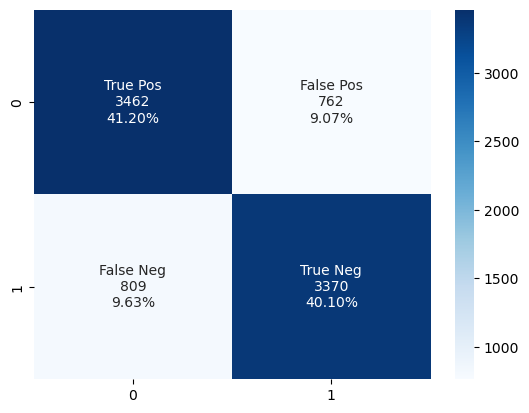

In [68]:
group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix(test_label, submission_xgb).flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix(test_label, submission_xgb).flatten()/np.sum(confusion_matrix(test_label, submission_xgb))]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix(test_label, submission_xgb),fmt='', cmap='Blues', annot=labels)